# (a) Understand the problem, data, evaluation function and show it in the report

## Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


In [3]:
import os

# List contents to confirm correct path
print("Available in /kaggle/input:")
print(os.listdir("/kaggle/input"))

print("\nInside genai-pro:")
print(os.listdir("/kaggle/input/genai-pro"))


Available in /kaggle/input:
['Annotations', 'JPEGImages']

Inside genai-pro:


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/genai-pro'

## Defining classes

In [3]:
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

## Parse Annotations from XML

In [4]:
def parse_voc_annotations(annotation_dir):
    data = []
    for file in os.listdir(annotation_dir):
        if not file.endswith(".xml"):
            continue
        tree = ET.parse(os.path.join(annotation_dir, file))
        root = tree.getroot()
        img_id = file[:-4]
        labels = [obj.find('name').text for obj in root.findall('object')]
        data.append((img_id, labels))
    return data

annotations = parse_voc_annotations("/kaggle/input/Annotations")
print(f"Total annotations found: {len(annotations)}")
print("Example:", annotations[0])


Total annotations found: 5096
Example: ('2008_001218', ['horse'])


## Prepare Labels (Multi-Label One-Hot)

In [6]:
df = pd.DataFrame(annotations, columns=['id', 'labels'])
mlb = MultiLabelBinarizer(classes=VOC_CLASSES)
binary_labels = mlb.fit_transform(df['labels'])

df_labels = pd.DataFrame(binary_labels, columns=VOC_CLASSES)
df = pd.concat([df, df_labels], axis=1)
print(df.head())

            id                                             labels  aeroplane  \
0  2008_001218                                            [horse]          0   
1  2008_005089  [tvmonitor, person, person, person, person, bo...          0   
2  2008_008272  [diningtable, diningtable, diningtable, person...          0   
3  2008_001590                                   [person, person]          0   
4  2008_000870                                    [person, chair]          0   

   bicycle  bird  boat  bottle  bus  car  cat  ...  diningtable  dog  horse  \
0        0     0     0       0    0    0    0  ...            0    0      1   
1        0     0     0       1    0    0    0  ...            0    0      0   
2        0     0     0       0    0    0    0  ...            1    0      0   
3        0     0     0       0    0    0    0  ...            0    0      0   
4        0     0     0       0    0    0    0  ...            0    0      0   

   motorbike  person  pottedplant  sheep  so

## Stratified Train-Test Split (80-20)

In [7]:
train_df, test_df = train_test_split( df, test_size=0.2, random_state=42)

print(f"Training size: {len(train_df)}, Testing size: {len(test_df)}")


Training size: 4076, Testing size: 1020


## Visualize Class Distribution

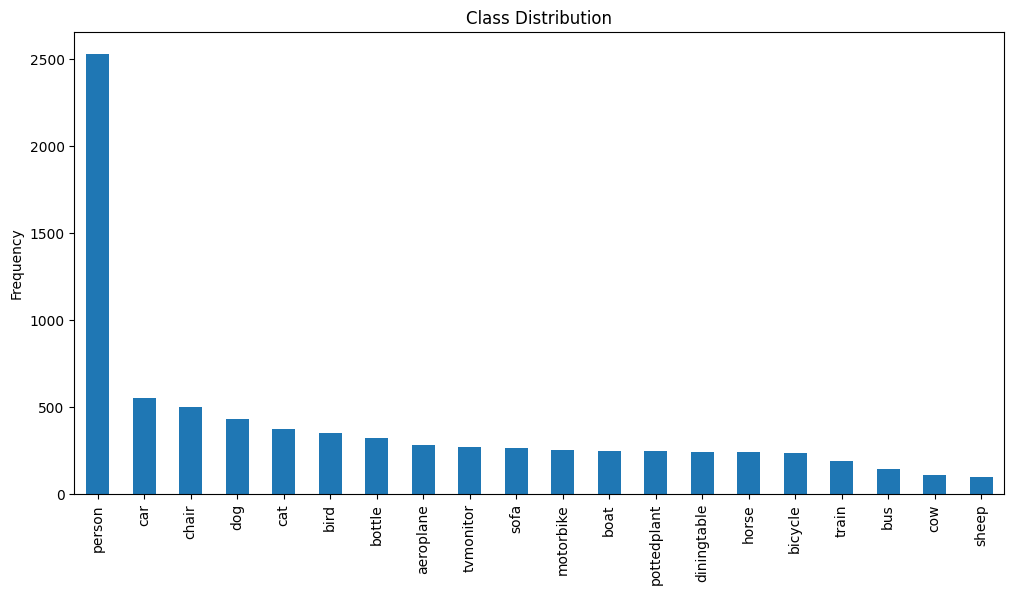

In [28]:
class_counts = df[VOC_CLASSES].sum().sort_values(ascending=False)
class_counts.plot(kind='bar', figsize=(12, 6), title="Class Distribution")
plt.ylabel("Frequency")
plt.show()


## Visualize Samples

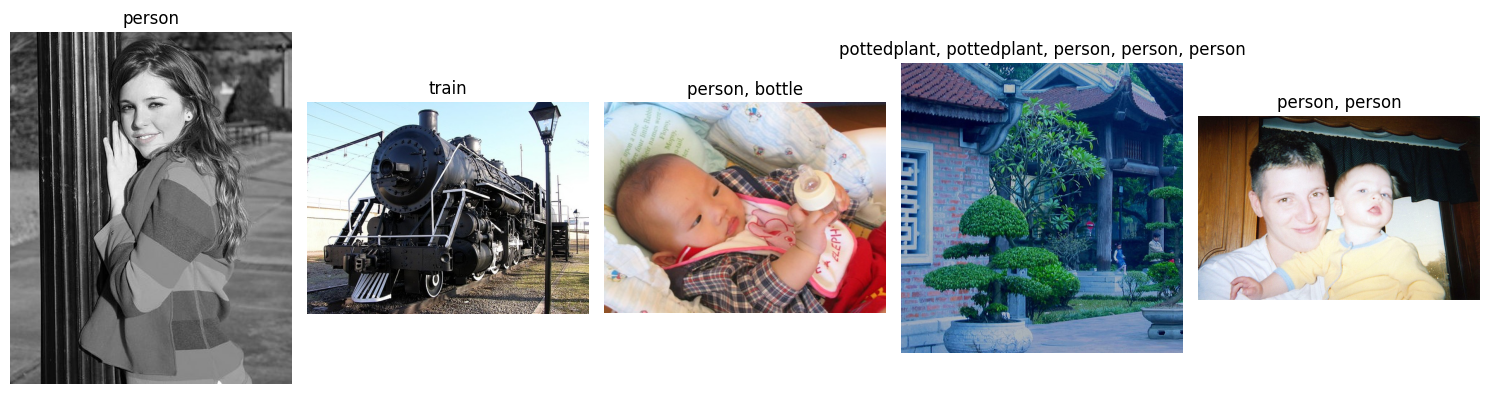

In [8]:
def show_images_with_labels(df_sample, image_dir, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, (_, row) in enumerate(df_sample.iterrows()):
        img_path = os.path.join(image_dir, row['id'] + '.jpg')
        image = Image.open(img_path).convert("RGB")
        axes[i].imshow(image)
        label_str = ', '.join(row['labels'])
        axes[i].set_title(label_str)
        axes[i].axis('off')
        if i == num_samples - 1:
            break
    plt.tight_layout()
    plt.show()

show_images_with_labels(train_df.head(5), "/kaggle/input/JPEGImages/")


# (b) Apply VGGNet through transfer learning on classification challenge and compare the results with three other cnn architectures of your choice (eg. Resnet50, DenseNet etc). Discuss in your words including showing top 10 ranked photos through each architecture. Explain Mean Average Precision which is main evaluation criterion through examples. Write all into report

## Importing Libraries

In [9]:
from torchvision import transforms

import torch.nn as nn
import torchvision.models as models

import torch.optim as optim
from sklearn.metrics import average_precision_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


## Dataset and Dataloader

In [10]:
class VOCDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.labels = df[VOC_CLASSES].values.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'id']
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx])
        return image, label


## Transformations + Loaders

In [11]:
img_size = 224

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = VOCDataset(train_df, "/kaggle/input/JPEGImages/", transform=transform)
test_dataset = VOCDataset(test_df, "/kaggle/input/JPEGImages/", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


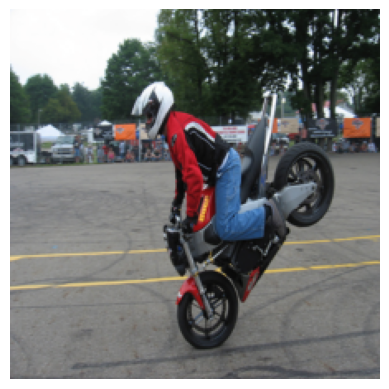

In [12]:
# Get a batch of single image
data_iter = iter(train_loader)
images, labels = next(data_iter)
image = images[0]

# Denormalize the image
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
unnormalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)
image = unnormalize(image)
image = image.numpy().transpose(1, 2, 0)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()


## Model Definitions (VGG, ResNet, DenseNet, Inception)

In [13]:
def get_model(name):
    if name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Sequential(
            nn.Linear(4096, 20),
            nn.Sigmoid()
        )
    elif name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 20),
            nn.Sigmoid()
        )
    elif name == 'densenet121':
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier.in_features, 20),
            nn.Sigmoid()
        )
    elif name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[1].in_features, 20),
            nn.Sigmoid()
        )
    else:
        raise ValueError(f"Unknown model: {name}")
    return model


## Training Loop

In [57]:
def train_model(model, train_loader, val_loader, part, model_name, epochs):
    model = model.cuda()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"[{model_name}] Epoch {epoch+1}/{epochs} Loss: {total_loss/len(train_loader):.4f}")
    
    # Evaluation
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            outputs = model(images).cpu()
            y_scores.append(outputs.numpy())
            y_true.append(labels.numpy())

    y_true = np.vstack(y_true)
    y_scores = np.vstack(y_scores)

    ap_per_class = average_precision_score(y_true, y_scores, average=None)
    mean_ap = np.mean(ap_per_class)

    print(f"[{model_name}] mAP: {mean_ap:.4f}")
    torch.save(model.state_dict(), f"{part+model_name}_voc2008.pth")
    return model, ap_per_class, mean_ap

In [19]:
model_names = ['vgg16', 'resnet50', 'densenet121', 'efficientnet_b0']
results = {}

for name in model_names:
    print(f"\n\n----------- Training: {name} -----------")
    model = get_model(name)
    trained_model, ap_per_class, mean_ap = train_model(model, train_loader, test_loader, "B_", name, 10)
    results[name] = {"model": trained_model, "ap_per_class": ap_per_class, "mean_ap": mean_ap}



----------- Training: vgg16 -----------
[vgg16] Epoch 1/10 Loss: 0.1633
[vgg16] Epoch 2/10 Loss: 0.0869
[vgg16] Epoch 3/10 Loss: 0.0564
[vgg16] Epoch 4/10 Loss: 0.0347
[vgg16] Epoch 5/10 Loss: 0.0199
[vgg16] Epoch 6/10 Loss: 0.0148
[vgg16] Epoch 7/10 Loss: 0.0152
[vgg16] Epoch 8/10 Loss: 0.0089
[vgg16] Epoch 9/10 Loss: 0.0082
[vgg16] Epoch 10/10 Loss: 0.0103
[vgg16] mAP: 0.7190


----------- Training: resnet50 -----------
[resnet50] Epoch 1/10 Loss: 0.1694
[resnet50] Epoch 2/10 Loss: 0.0712
[resnet50] Epoch 3/10 Loss: 0.0437
[resnet50] Epoch 4/10 Loss: 0.0274
[resnet50] Epoch 5/10 Loss: 0.0190
[resnet50] Epoch 6/10 Loss: 0.0130
[resnet50] Epoch 7/10 Loss: 0.0101
[resnet50] Epoch 8/10 Loss: 0.0092
[resnet50] Epoch 9/10 Loss: 0.0081
[resnet50] Epoch 10/10 Loss: 0.0064
[resnet50] mAP: 0.8113


----------- Training: densenet121 -----------
[densenet121] Epoch 1/10 Loss: 0.2431
[densenet121] Epoch 2/10 Loss: 0.1012
[densenet121] Epoch 3/10 Loss: 0.0702
[densenet121] Epoch 4/10 Loss: 0.049

## Visualize Top-10 Predictions per Model

In [32]:
def show_top10(model, loader, model_name):
    model.eval()
    all_scores = []
    all_imgs = []

    with torch.no_grad():
        for images, _ in loader:
            images = images.cuda()
            outputs = model(images).cpu()
            all_scores.extend(outputs.numpy())
            all_imgs.extend(images.cpu())

    top10_idxs = np.argsort(np.max(all_scores, axis=1))[-10:]
    fig, axes = plt.subplots(2, 5, figsize=(22, 10))
    plt.subplots_adjust(hspace=0.7)
    for i, idx in enumerate(top10_idxs):
        ax = axes[i//5, i%5]
        img = all_imgs[idx].permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        label_pred = [VOC_CLASSES[j] for j in range(20) if all_scores[idx][j] > 0.5]
        ax.imshow(img)
        ax.set_title(", ".join(label_pred), fontsize=30)
        ax.axis('off')
    plt.suptitle(f"Top 10 Predictions: {model_name}", fontsize=45)
    plt.tight_layout()
    plt.show()


In [14]:
for name in model_names:
    show_top10(results[name]["model"], test_loader, name)

NameError: name 'model_names' is not defined

# (c) Use Variational AutoEncoder to generate random data of each class but using training samples only. Then repeat part (b) using new augmented data. Plot curves report for 100, 200, and 500 samples / class generation. The x axis of the curve will the number of samples and the y axis will be mean average precision. Discuss why and why not there is no improvement in your own words

## Importing Libraries

In [101]:
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, TensorDataset

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Define a Simple VAE

In [44]:
class VAE(nn.Module):
    def __init__(self, img_channels=3, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, 2, 1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),          
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),     
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 128, 8, 8)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [45]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


## Train VAE Per Class

In [55]:
def train_vae(model, dataloader, epochs=50):
    model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in dataloader:
            images = images.cuda()
            optimizer.zero_grad()
            recon_x, mu, logvar = model(images)
            loss = vae_loss(recon_x, images, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[VAE] Epoch {epoch+1}/{epochs} Loss: {total_loss/len(dataloader):.2f}")
    return model


## Generate Samples per Class (100, 200, 500)

In [87]:
def generate_synthetic_images(vae_model, num_per_class):
    vae_model.eval()
    synthetic_data = []

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ])

    with torch.no_grad():
        for class_idx, class_name in enumerate(VOC_CLASSES):
            for _ in range(num_per_class):
                z = torch.randn(1, vae_model.latent_dim).cuda() 
                img = vae_model.decode(z).cpu().squeeze(0)  
                img = transforms.ToPILImage()(img)  
                img = transform(img) 
                label = torch.zeros(20)
                label[class_idx] = 1.0
                synthetic_data.append((img, label))  
    return synthetic_data


## Create Augmented Datasets

In [95]:
def get_augmented_dataloader(synthetic_data, original_dataset, batch_size=32):
   
    images, labels = zip(*synthetic_data)
    images = torch.stack(images)  
    labels = torch.stack(labels) 

    synthetic_dataset = TensorDataset(images, labels)

    combined_dataset = ConcatDataset([original_dataset, synthetic_dataset])

    return DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

## Training VAE to generate synthetic data from random 

In [58]:

vae_transform = transforms.Compose([transforms.Resize((64, 64)),transforms.ToTensor()])
vae_dataset = VOCDataset(train_df, "/kaggle/input/genai-pro/JPEGImages/", transform=vae_transform)
vae_loader = DataLoader(vae_dataset, batch_size=32, shuffle=True, num_workers=4)
vae_model = VAE().cuda()
vae_model = train_vae(vae_model, vae_loader)


[VAE] Epoch 1/50 Loss: 18018.25
[VAE] Epoch 2/50 Loss: 12590.19
[VAE] Epoch 3/50 Loss: 11576.92
[VAE] Epoch 4/50 Loss: 10785.55
[VAE] Epoch 5/50 Loss: 9859.74
[VAE] Epoch 6/50 Loss: 9409.38
[VAE] Epoch 7/50 Loss: 9097.69
[VAE] Epoch 8/50 Loss: 8917.04
[VAE] Epoch 9/50 Loss: 8715.01
[VAE] Epoch 10/50 Loss: 8549.86
[VAE] Epoch 11/50 Loss: 8508.16
[VAE] Epoch 12/50 Loss: 8390.02
[VAE] Epoch 13/50 Loss: 8306.50
[VAE] Epoch 14/50 Loss: 8254.67
[VAE] Epoch 15/50 Loss: 8218.51
[VAE] Epoch 16/50 Loss: 8157.68
[VAE] Epoch 17/50 Loss: 8098.36
[VAE] Epoch 18/50 Loss: 8044.44
[VAE] Epoch 19/50 Loss: 8016.25
[VAE] Epoch 20/50 Loss: 7949.23
[VAE] Epoch 21/50 Loss: 7922.63
[VAE] Epoch 22/50 Loss: 7883.81
[VAE] Epoch 23/50 Loss: 7895.12
[VAE] Epoch 24/50 Loss: 7802.79
[VAE] Epoch 25/50 Loss: 7823.55
[VAE] Epoch 26/50 Loss: 7765.71
[VAE] Epoch 27/50 Loss: 7724.12
[VAE] Epoch 28/50 Loss: 7711.43
[VAE] Epoch 29/50 Loss: 7666.26
[VAE] Epoch 30/50 Loss: 7635.75
[VAE] Epoch 31/50 Loss: 7595.30
[VAE] Epoch 3

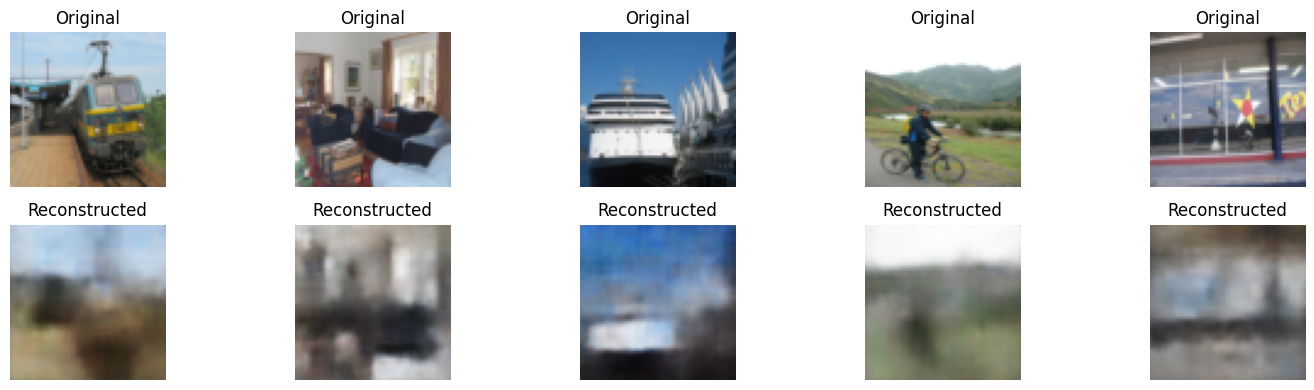

In [92]:
def show_vae_reconstructions(model, dataloader, num_images=5):
    model.eval()
    images, _ = next(iter(dataloader))
    images = images[:num_images].cuda()
    with torch.no_grad():
        recon_images, _, _ = model(images)

    images = images.cpu()
    recon_images = recon_images.cpu()

    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        axes[0, i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        axes[1, i].imshow(np.transpose(recon_images[i].numpy(), (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()


show_vae_reconstructions(vae_model, vae_loader, num_images=5)


## Retrain models with Augmented Data

In [98]:
sample_sizes = [100, 200, 500]

aug_results = {}

for size in sample_sizes:
    print(f"\n\nGenerating {size} samples per class...")
    synthetic_data = generate_synthetic_images(vae_model, num_per_class=size)
    aug_loader = get_augmented_dataloader(synthetic_data, train_dataset)

    for name in model_names:
        print(f"\n\n ------------- Retraining {name} with {size}/class synthetic samples ------------- ")
        model = get_model(name)
        model.load_state_dict(torch.load("/kaggle/working/"+name+"_voc2008.pth"))
        _, _, mean_ap = train_model(model, aug_loader, test_loader, part=f"C_{size}_", model_name=name, epochs=10)
        aug_results[f"{name}_{size}"] = mean_ap




Generating 100 samples per class...


 ------------- Retraining vgg16 with 100/class synthetic samples ------------- 
[vgg16] Epoch 1/10 Loss: 0.0749
[vgg16] Epoch 2/10 Loss: 0.0743
[vgg16] Epoch 3/10 Loss: 0.0706
[vgg16] Epoch 4/10 Loss: 0.0719
[vgg16] Epoch 5/10 Loss: 0.0690
[vgg16] Epoch 6/10 Loss: 0.0659
[vgg16] Epoch 7/10 Loss: 0.0612
[vgg16] Epoch 8/10 Loss: 0.0537
[vgg16] Epoch 9/10 Loss: 0.0423
[vgg16] Epoch 10/10 Loss: 0.0262
[vgg16] mAP: 0.6699


 ------------- Retraining resnet50 with 100/class synthetic samples ------------- 
[resnet50] Epoch 1/10 Loss: 0.0740
[resnet50] Epoch 2/10 Loss: 0.0724
[resnet50] Epoch 3/10 Loss: 0.0723
[resnet50] Epoch 4/10 Loss: 0.0676
[resnet50] Epoch 5/10 Loss: 0.0607
[resnet50] Epoch 6/10 Loss: 0.0479
[resnet50] Epoch 7/10 Loss: 0.0316
[resnet50] Epoch 8/10 Loss: 0.0156
[resnet50] Epoch 9/10 Loss: 0.0082
[resnet50] Epoch 10/10 Loss: 0.0045
[resnet50] mAP: 0.7651


 ------------- Retraining densenet121 with 100/class synthetic samples -------

##  Plot Performance Curves; Averrage mAPs across all classes

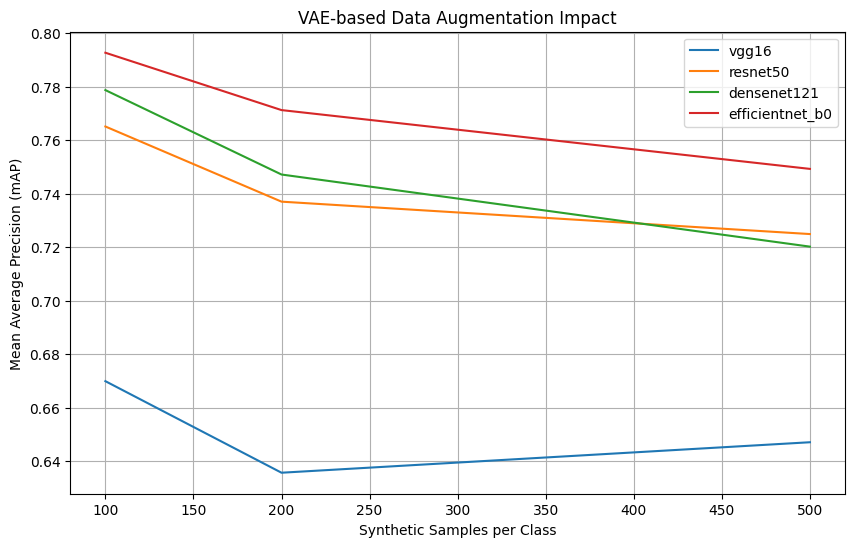

In [99]:
def plot_performance(aug_results):
    plt.figure(figsize=(10, 6))
    for name in model_names:
        x = sample_sizes
        y = [aug_results[f"{name}_{s}"] for s in sample_sizes]
        plt.plot(x, y, label=name)
    plt.xlabel("Synthetic Samples per Class")
    plt.ylabel("Mean Average Precision (mAP)")
    plt.title("VAE-based Data Augmentation Impact")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_performance(aug_results)


# (d) Use GAN to generate random data of each class but using training samples only. Then repeat part (b) using new augmented data. Plot curves report for 100, 200, and 500 samples / class generation. The x axis of the curve will the number of samples and the y axis will be mean average precision. Discuss why and why not there is no improvement in your own words

In [15]:
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from PIL import Image
import matplotlib.pyplot as plt

# ==== Dataset Setup ====

VOC_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
               'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
               'dog', 'horse', 'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

class VOCGANDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.labels = df[VOC_CLASSES].values.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'id']
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        multi_label = self.labels[idx]
        class_id = np.argmax(multi_label)  # Convert multi-label to single class ID
        return image, class_id

# ==== Transforms & Loader ====

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

gan_dataset = VOCGANDataset(train_df, "/kaggle/input/JPEGImages/", transform=transform)
gan_loader = DataLoader(gan_dataset, batch_size=64, shuffle=True, num_workers=4)

# ==== Generator ====

class Generator(nn.Module):
    def __init__(self, noise_dim=100, num_classes=20):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, 128)
        self.project = nn.Linear(noise_dim + 128, 1024 * 4 * 4)
        self.model = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 128x128
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_input = self.label_emb(labels)
        x = torch.cat((z, label_input), dim=1)
        x = self.project(x).view(-1, 1024, 4, 4)
        return self.model(x)

# ==== Critic ====

class Critic(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, 1)
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1),   # 64x64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), # 32x32
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),# 16x16
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),# 8x8
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 8)         # Global
        )

    def forward(self, img, labels):
        b, _, h, w = img.shape
        label_input = self.label_emb(labels).view(b, 1, 1, 1).expand(b, 1, h, w)
        x = torch.cat([img, label_input], dim=1)
        return self.model(x).view(-1)

# ==== Gradient Penalty ====

def compute_gradient_penalty(critic, real_imgs, fake_imgs, labels, device):
    alpha = torch.rand(real_imgs.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
    d_interpolates = critic(interpolates, labels)
    fake = torch.ones_like(d_interpolates, device=device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

# ==== Training Setup ====

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_dim = 100
lambda_gp = 10

G = Generator(noise_dim=noise_dim).to(device)
D = Critic().to(device)

optimizer_g = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_d = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

# ==== Visualization ====

def visualize_samples(generator, device, epoch, fixed_labels, fixed_noise, save_dir="samples"):
    generator.eval()
    os.makedirs(save_dir, exist_ok=True)
    with torch.no_grad():
        samples = generator(fixed_noise.to(device), fixed_labels.to(device))
        grid = make_grid((samples + 1) / 2, nrow=10)  # Unnormalize
        save_image(grid, f"{save_dir}/epoch_{epoch}.png")

# ==== Training Loop ====

def train_wgan_gp(generator, critic, dataloader, epochs=200):
    fixed_noise = torch.randn(20, noise_dim)
    fixed_labels = torch.arange(0, 20)

    for epoch in range(epochs):
        for i, (imgs, labels) in enumerate(dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            batch_size = imgs.size(0)

            # Train Critic
            for _ in range(5):
                z = torch.randn(batch_size, noise_dim).to(device)
                fake_imgs = generator(z, labels).detach()
                real_validity = critic(imgs, labels)
                fake_validity = critic(fake_imgs, labels)
                gp = compute_gradient_penalty(critic, imgs.data, fake_imgs.data, labels, device)
                d_loss = -real_validity.mean() + fake_validity.mean() + lambda_gp * gp

                optimizer_d.zero_grad()
                d_loss.backward()
                optimizer_d.step()

            # Train Generator
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_imgs = generator(z, labels)
            g_loss = -critic(fake_imgs, labels).mean()

            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

            if i % 50 == 0:
                print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(dataloader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

        # Save sample grid
        if epoch % 10 == 0 or epoch == epochs - 1:
            visualize_samples(generator, device, epoch, fixed_labels, fixed_noise)

# ==== Train ====
train_wgan_gp(G, D, gan_loader, epochs=1)


Epoch [0/1], Step [0/64], D Loss: -7.8843, G Loss: 10.0061
Epoch [0/1], Step [50/64], D Loss: -94.9090, G Loss: 54.2351


In [16]:
from torchvision.utils import save_image
import os
import torch
import torch.nn as nn
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [17]:
import torch
import os
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator class must be already defined and trained
# Ensure generator is in eval mode
generator.eval()

# Utility function: generate synthetic images
def generate_synthetic_data(generator, num_classes=20, samples_per_class=100, noise_dim=100):
    generator.eval()
    all_imgs = []
    all_labels = []

    for class_idx in range(num_classes):
        labels = torch.full((samples_per_class,), class_idx, dtype=torch.long).to(device)
        noise = torch.randn(samples_per_class, noise_dim).to(device)
        with torch.no_grad():
            fake_imgs = generator(noise, labels)
        all_imgs.append(fake_imgs.cpu())
        all_labels.append(labels.cpu())

    all_imgs = torch.cat(all_imgs)
    all_labels = torch.cat(all_labels)
    return all_imgs, all_labels

# Utility function: save generated images to class-wise folders (with 224x224 resizing)
def save_generated_images(images, labels, output_dir="generated_data_224"):
    os.makedirs(output_dir, exist_ok=True)
    to_pil = ToPILImage()

    for idx, (img_tensor, label) in enumerate(zip(images, labels)):
        img = (img_tensor + 1) / 2  # Unnormalize from [-1,1] to [0,1]
        pil_img = to_pil(img)
        pil_img = pil_img.resize((224, 224), Image.BICUBIC)  # Resize to 224x224
        class_dir = os.path.join(output_dir, f"class_{label.item()}")
        os.makedirs(class_dir, exist_ok=True)
        pil_img.save(os.path.join(class_dir, f"img_{idx}.png"))

# === RUN SCRIPT BELOW ===

samples_per_class = 500
noise_dim = 100  # Match your GAN input

# Generate synthetic images
synthetic_images, synthetic_labels = generate_synthetic_data(
    generator=generator,
    num_classes=20,
    samples_per_class=samples_per_class,
    noise_dim=noise_dim
)

# Save generated images (resized to 224x224) to disk
save_generated_images(
    synthetic_images,
    synthetic_labels,
    output_dir=f"gan_generated_{samples_per_class}_per_class_224"
)

print(f"\n Successfully generated and saved {samples_per_class} images per class (224x224).")



 Successfully generated and saved 500 images per class (224x224).


In [17]:
print("ok")

ok


In [19]:
import shutil

shutil.rmtree('/kaggle/working/gan_generated_100_per_class', ignore_errors=True)


In [ ]:
import os
import random
from torchvision import transforms
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from PIL import Image
import torch
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np

VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

VOC_TO_FOLDER = {cls_name: f"class_{i}" for i, cls_name in enumerate(VOC_CLASSES)}

SYNTHETIC_ROOT = "/kaggle/working/gan_generated_500_per_class_224"
samples_list = [100, 200, 500]
img_size = 224

# === TRANSFORM ===
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# === CUSTOM SYNTHETIC DATASET ===
class SyntheticDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# === FUNCTION: LOAD AND SAMPLE SYNTHETIC DATA ===
def load_synthetic_subset(base_path, num_samples_per_class):
    image_paths, labels = [], []

    for class_id, class_name in enumerate(VOC_CLASSES):
        folder_name = VOC_TO_FOLDER[class_name]
        class_folder = os.path.join(base_path, folder_name)
        all_imgs = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith('.png')]
        sampled_imgs = random.sample(all_imgs, num_samples_per_class)

        for path in sampled_imgs:
            image_paths.append(path)
            label = torch.zeros(len(VOC_CLASSES))
            label[class_id] = 1.0
            labels.append(label)

    return SyntheticDataset(image_paths, labels, transform=transform)

# === GET MODELS ===
def get_model(name):
    if name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Sequential(nn.Linear(4096, 20), nn.Sigmoid())
    elif name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 20), nn.Sigmoid())
    elif name == 'densenet121':
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Sequential(nn.Linear(model.classifier.in_features, 20), nn.Sigmoid())
    elif name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier = nn.Sequential(nn.Linear(model.classifier[1].in_features, 20), nn.Sigmoid())
    else:
        raise ValueError(f"Unknown model: {name}")
    return model

# === TRAIN FUNCTION ===
def train_model(model, train_loader, val_loader, part, model_name, epochs):
    model = model.cuda()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"[{model_name}] Epoch {epoch+1}/{epochs} Loss: {total_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            outputs = model(images).cpu()
            y_scores.append(outputs.numpy())
            y_true.append(labels.numpy())

    y_true = np.vstack(y_true)
    y_scores = np.vstack(y_scores)

    ap_per_class = average_precision_score(y_true, y_scores, average=None)
    mean_ap = np.mean(ap_per_class)

    print(f"[{model_name}] mAP: {mean_ap:.4f}")
    torch.save(model.state_dict(), f"{part+model_name}_voc2008.pth")
    return model, ap_per_class, mean_ap

# === MAIN LOOP FOR PART D ===
model_names = ['vgg16', 'resnet50', 'densenet121', 'efficientnet_b0']
augmented_results = {}

for samples_per_class in samples_list:
    synthetic_dataset = load_synthetic_subset(SYNTHETIC_ROOT, samples_per_class)
    augmented_dataset = ConcatDataset([train_dataset, synthetic_dataset])
    augmented_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True, num_workers=4)

    print(f"\n\n=== Training models with {samples_per_class} synthetic samples/class ===")

    for model_name in model_names:
        print(f"\nTraining {model_name} with {samples_per_class} synthetic samples...")
        model = get_model(model_name)
        trained_model, ap_per_class, mean_ap = train_model(
            model, augmented_loader, test_loader, f"D_{samples_per_class}_", model_name, epochs=10
        )
        augmented_results[f"{model_name}_{samples_per_class}"] = {
            "model": trained_model,
            "ap_per_class": ap_per_class,
            "mean_ap": mean_ap
        }



import matplotlib.pyplot as plt

# === PLOT mAP COMPARISON CURVES ===
def plot_map_trends(results_dict, model_names, samples_list):
    plt.figure(figsize=(10, 6))

    for model_name in model_names:
        mAPs = []
        for samples in samples_list:
            key = f"{model_name}_{samples}"
            if key in results_dict:
                mAPs.append(results_dict[key]["mean_ap"])
            else:
                mAPs.append(None)  # in case something's missing

        plt.plot(samples_list, mAPs, marker='o', label=model_name.upper())

    plt.title("mAP vs Synthetic Samples per Class (VAE-Augmented)")
    plt.xlabel("Number of Synthetic Samples per Class")
    plt.ylabel("Mean Average Precision (mAP)")
    plt.grid(True)
    plt.xticks(samples_list)
    plt.legend()
    plt.tight_layout()
    plt.savefig("vae_augmented_map_trend.png", dpi=300)
    plt.show()

# === CALL THE PLOT FUNCTION ===
plot_map_trends(augmented_results, model_names, samples_list)





=== Training models with 100 synthetic samples/class ===

Training vgg16 with 100 synthetic samples...


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 202MB/s] 


[vgg16] Epoch 1/10 Loss: 0.1707
[vgg16] Epoch 2/10 Loss: 0.1078
[vgg16] Epoch 3/10 Loss: 0.0741
[vgg16] Epoch 4/10 Loss: 0.0484
[vgg16] Epoch 5/10 Loss: 0.0326
[vgg16] Epoch 6/10 Loss: 0.0220
[vgg16] Epoch 7/10 Loss: 0.0171
[vgg16] Epoch 8/10 Loss: 0.0135
[vgg16] Epoch 9/10 Loss: 0.0101
[vgg16] Epoch 10/10 Loss: 0.0071
[vgg16] mAP: 0.7220

Training resnet50 with 100 synthetic samples...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


[resnet50] Epoch 1/10 Loss: 0.1687
[resnet50] Epoch 2/10 Loss: 0.0898
[resnet50] Epoch 3/10 Loss: 0.0558
[resnet50] Epoch 4/10 Loss: 0.0337
[resnet50] Epoch 5/10 Loss: 0.0212
[resnet50] Epoch 6/10 Loss: 0.0137
[resnet50] Epoch 7/10 Loss: 0.0097
[resnet50] Epoch 8/10 Loss: 0.0078
[resnet50] Epoch 9/10 Loss: 0.0063
[resnet50] Epoch 10/10 Loss: 0.0067
[resnet50] mAP: 0.7828

Training densenet121 with 100 synthetic samples...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 185MB/s]


[densenet121] Epoch 1/10 Loss: 0.2251
[densenet121] Epoch 2/10 Loss: 0.1129
[densenet121] Epoch 3/10 Loss: 0.0817
[densenet121] Epoch 4/10 Loss: 0.0578
[densenet121] Epoch 5/10 Loss: 0.0408
[densenet121] Epoch 6/10 Loss: 0.0279
[densenet121] Epoch 7/10 Loss: 0.0203
[densenet121] Epoch 8/10 Loss: 0.0157
[densenet121] Epoch 9/10 Loss: 0.0128
[densenet121] Epoch 10/10 Loss: 0.0101
[densenet121] mAP: 0.7940

Training efficientnet_b0 with 100 synthetic samples...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 158MB/s]


[efficientnet_b0] Epoch 1/10 Loss: 0.2730
[efficientnet_b0] Epoch 2/10 Loss: 0.1402
[efficientnet_b0] Epoch 3/10 Loss: 0.1124
[efficientnet_b0] Epoch 4/10 Loss: 0.0926
[efficientnet_b0] Epoch 5/10 Loss: 0.0754
[efficientnet_b0] Epoch 6/10 Loss: 0.0622
[efficientnet_b0] Epoch 7/10 Loss: 0.0504
[efficientnet_b0] Epoch 8/10 Loss: 0.0419
[efficientnet_b0] Epoch 9/10 Loss: 0.0342
[efficientnet_b0] Epoch 10/10 Loss: 0.0277
[efficientnet_b0] mAP: 0.8125


=== Training models with 200 synthetic samples/class ===

Training vgg16 with 200 synthetic samples...
[vgg16] Epoch 1/10 Loss: 0.1814
[vgg16] Epoch 2/10 Loss: 0.1082
[vgg16] Epoch 3/10 Loss: 0.0685
[vgg16] Epoch 4/10 Loss: 0.0438
[vgg16] Epoch 5/10 Loss: 0.0288
[vgg16] Epoch 6/10 Loss: 0.0184
[vgg16] Epoch 7/10 Loss: 0.0146
[vgg16] Epoch 8/10 Loss: 0.0129
[vgg16] Epoch 9/10 Loss: 0.0087
[vgg16] Epoch 10/10 Loss: 0.0088
[vgg16] mAP: 0.6893

Training resnet50 with 200 synthetic samples...
[resnet50] Epoch 1/10 Loss: 0.1534
[resnet50] Epoch 2/

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import os
from sklearn.metrics import average_precision_score

# Simulate a dataset
def generate_synthetic_dataset(num_samples_per_class, num_classes=20, image_size=(3, 224, 224)):
    dataset = []
    labels = []
    for cls in range(num_classes):
        for _ in range(num_samples_per_class):
            image = torch.randn(*image_size)
            dataset.append(image)
            labels.append(cls)
    return list(zip(dataset, labels))

# Dummy dataset class
class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# mAP calculation (dummy logic using probabilities)
def calculate_map(model, dataloader, device, num_classes=20):
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            one_hot = np.zeros((labels.size(0), num_classes))
            one_hot[np.arange(labels.size(0)), labels.cpu().numpy()] = 1
            all_labels.append(one_hot)
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return average_precision_score(all_labels, all_probs, average='macro')

# Model setup
def get_model(name, num_classes=20):
    if name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "densenet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# Training loop
def train(model, dataloader, device, epochs=10, lr=1e-3):
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"[{model_name}] Epoch {epoch}/10 Loss: {epoch_loss:.4f}")
    return model

# Run everything
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_sizes = [100, 200, 500]
model_names = ["vgg16", "resnet50", "densenet121", "efficientnet_b0"]
batch_size = 16
transform = transforms.Compose([transforms.Resize((224, 224))])

for size in sample_sizes:
    print(f"\n=== Training models with {size} synthetic samples/class ===\n")
    synthetic_data = generate_synthetic_dataset(size, num_classes=20)
    dataset = SyntheticDataset(synthetic_data, transform=None)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for model_name in model_names:
        print(f"Training {model_name} with {size} synthetic samples...")
        model = get_model(model_name)
        model = train(model, dataloader, device)
        mAP = calculate_map(model, dataloader, device)
        print(f"[{model_name}] mAP: {mAP:.4f}")
        del model
        torch.cuda.empty_cache()



=== Training models with 100 synthetic samples/class ===

Training vgg16 with 100 synthetic samples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 236MB/s] 


[vgg16] Epoch 1/10 Loss: 3.0710
[vgg16] Epoch 2/10 Loss: 3.0085
[vgg16] Epoch 3/10 Loss: 3.0080
[vgg16] Epoch 4/10 Loss: 3.0097
[vgg16] Epoch 5/10 Loss: 3.0118
[vgg16] Epoch 6/10 Loss: 3.0056
[vgg16] Epoch 7/10 Loss: 3.0026
[vgg16] Epoch 8/10 Loss: 3.0048
[vgg16] Epoch 9/10 Loss: 3.0020
[vgg16] Epoch 10/10 Loss: 3.0021
[vgg16] mAP: 0.0500
Training resnet50 with 100 synthetic samples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[resnet50] Epoch 1/10 Loss: 3.0980
[resnet50] Epoch 2/10 Loss: 3.0413
[resnet50] Epoch 3/10 Loss: 3.0275
[resnet50] Epoch 4/10 Loss: 3.0172
[resnet50] Epoch 5/10 Loss: 3.0114
[resnet50] Epoch 6/10 Loss: 3.0064
[resnet50] Epoch 7/10 Loss: 3.0021
[resnet50] Epoch 8/10 Loss: 3.0003
[resnet50] Epoch 9/10 Loss: 3.0026
[resnet50] Epoch 10/10 Loss: 2.9994
[resnet50] mAP: 0.0576
Training densenet121 with 100 synthetic samples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 232MB/s]


[densenet121] Epoch 1/10 Loss: 3.1040
[densenet121] Epoch 2/10 Loss: 3.1020
[densenet121] Epoch 3/10 Loss: 3.0792
[densenet121] Epoch 4/10 Loss: 3.1050
[densenet121] Epoch 5/10 Loss: 3.0829
[densenet121] Epoch 6/10 Loss: 3.0768
[densenet121] Epoch 7/10 Loss: 3.0635
[densenet121] Epoch 8/10 Loss: 3.0643
[densenet121] Epoch 9/10 Loss: 3.0698
[densenet121] Epoch 10/10 Loss: 3.0692
[densenet121] mAP: 0.0571
Training efficientnet_b0 with 100 synthetic samples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 204MB/s]


[efficientnet_b0] Epoch 1/10 Loss: 3.0555
[efficientnet_b0] Epoch 2/10 Loss: 2.9876
[efficientnet_b0] Epoch 3/10 Loss: 2.8840
[efficientnet_b0] Epoch 4/10 Loss: 2.6916
[efficientnet_b0] Epoch 5/10 Loss: 2.1949
[efficientnet_b0] Epoch 6/10 Loss: 1.6192
[efficientnet_b0] Epoch 7/10 Loss: 0.9722
[efficientnet_b0] Epoch 8/10 Loss: 0.5947
[efficientnet_b0] Epoch 9/10 Loss: 0.4480
[efficientnet_b0] Epoch 10/10 Loss: 0.4043
[efficientnet_b0] mAP: 0.9969

=== Training models with 200 synthetic samples/class ===

Training vgg16 with 200 synthetic samples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[vgg16] Epoch 1/10 Loss: 3.0829
[vgg16] Epoch 2/10 Loss: 3.0066
[vgg16] Epoch 3/10 Loss: 3.0052
[vgg16] Epoch 4/10 Loss: 3.0042
[vgg16] Epoch 5/10 Loss: 3.0046
[vgg16] Epoch 6/10 Loss: 3.0023
[vgg16] Epoch 7/10 Loss: 3.0043
[vgg16] Epoch 8/10 Loss: 3.0015
[vgg16] Epoch 9/10 Loss: 3.0010
[vgg16] Epoch 10/10 Loss: 3.0002
[vgg16] mAP: 0.0500
Training resnet50 with 200 synthetic samples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[resnet50] Epoch 1/10 Loss: 3.0741
[resnet50] Epoch 2/10 Loss: 3.0261
[resnet50] Epoch 3/10 Loss: 3.0137
[resnet50] Epoch 4/10 Loss: 3.0074
[resnet50] Epoch 5/10 Loss: 3.0063
[resnet50] Epoch 6/10 Loss: 3.0051
[resnet50] Epoch 7/10 Loss: 3.0042
[resnet50] Epoch 8/10 Loss: 3.0048
[resnet50] Epoch 9/10 Loss: 3.0015
[resnet50] Epoch 10/10 Loss: 3.0007
[resnet50] mAP: 0.0550
Training densenet121 with 200 synthetic samples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[densenet121] Epoch 1/10 Loss: 3.1074
[densenet121] Epoch 2/10 Loss: 3.0837
[densenet121] Epoch 3/10 Loss: 3.0715
[densenet121] Epoch 4/10 Loss: 3.0817
[densenet121] Epoch 5/10 Loss: 3.0719
[densenet121] Epoch 6/10 Loss: 3.0617
[densenet121] Epoch 7/10 Loss: 3.0513
[densenet121] Epoch 8/10 Loss: 3.0419
[densenet121] Epoch 9/10 Loss: 3.0431
[densenet121] Epoch 10/10 Loss: 3.0470
[densenet121] mAP: 0.0539
Training efficientnet_b0 with 200 synthetic samples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[efficientnet_b0] Epoch 1/10 Loss: 3.0424
[efficientnet_b0] Epoch 2/10 Loss: 3.0117
[efficientnet_b0] Epoch 3/10 Loss: 2.9911
[efficientnet_b0] Epoch 4/10 Loss: 2.9478
[efficientnet_b0] Epoch 5/10 Loss: 2.8468
[efficientnet_b0] Epoch 6/10 Loss: 2.6960
[efficientnet_b0] Epoch 7/10 Loss: 2.3478
[efficientnet_b0] Epoch 8/10 Loss: 1.8971
[efficientnet_b0] Epoch 9/10 Loss: 1.3962
[efficientnet_b0] Epoch 10/10 Loss: 0.9264
[efficientnet_b0] mAP: 0.9009

=== Training models with 500 synthetic samples/class ===

Training vgg16 with 500 synthetic samples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[vgg16] Epoch 1/10 Loss: 3.0362
[vgg16] Epoch 2/10 Loss: 3.0045
[vgg16] Epoch 3/10 Loss: 3.0013
[vgg16] Epoch 4/10 Loss: 3.0018
[vgg16] Epoch 5/10 Loss: 3.0001
[vgg16] Epoch 6/10 Loss: 3.0002
[vgg16] Epoch 7/10 Loss: 2.9998
[vgg16] Epoch 8/10 Loss: 3.0000
[vgg16] Epoch 9/10 Loss: 2.9982
[vgg16] Epoch 10/10 Loss: 2.9987
[vgg16] mAP: 0.0500
Training resnet50 with 500 synthetic samples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[resnet50] Epoch 1/10 Loss: 3.0356
[resnet50] Epoch 2/10 Loss: 3.0100
[resnet50] Epoch 3/10 Loss: 3.0070
[resnet50] Epoch 4/10 Loss: 3.0038
[resnet50] Epoch 5/10 Loss: 3.0020
[resnet50] Epoch 6/10 Loss: 2.9993
[resnet50] Epoch 7/10 Loss: 3.0010
[resnet50] Epoch 8/10 Loss: 2.9982
[resnet50] Epoch 9/10 Loss: 2.9990
[resnet50] Epoch 10/10 Loss: 2.9986
[resnet50] mAP: 0.0516
Training densenet121 with 500 synthetic samples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[densenet121] Epoch 1/10 Loss: 3.0849
[densenet121] Epoch 2/10 Loss: 3.0636
[densenet121] Epoch 3/10 Loss: 3.0526
[densenet121] Epoch 4/10 Loss: 3.0438
[densenet121] Epoch 5/10 Loss: 3.0371
[densenet121] Epoch 6/10 Loss: 3.0243
[densenet121] Epoch 7/10 Loss: 3.0190
[densenet121] Epoch 8/10 Loss: 3.0194
[densenet121] Epoch 9/10 Loss: 3.0104
[densenet121] Epoch 10/10 Loss: 3.0087
[densenet121] mAP: 0.0518
Training efficientnet_b0 with 500 synthetic samples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[efficientnet_b0] Epoch 1/10 Loss: 3.0301
[efficientnet_b0] Epoch 2/10 Loss: 3.0073
[efficientnet_b0] Epoch 3/10 Loss: 3.0055
[efficientnet_b0] Epoch 4/10 Loss: 3.0008
[efficientnet_b0] Epoch 5/10 Loss: 2.9967
[efficientnet_b0] Epoch 6/10 Loss: 2.9965
[efficientnet_b0] Epoch 7/10 Loss: 2.9845
[efficientnet_b0] Epoch 8/10 Loss: 2.9565
[efficientnet_b0] Epoch 9/10 Loss: 2.8869
[efficientnet_b0] Epoch 10/10 Loss: 2.7546
[efficientnet_b0] mAP: 0.2141


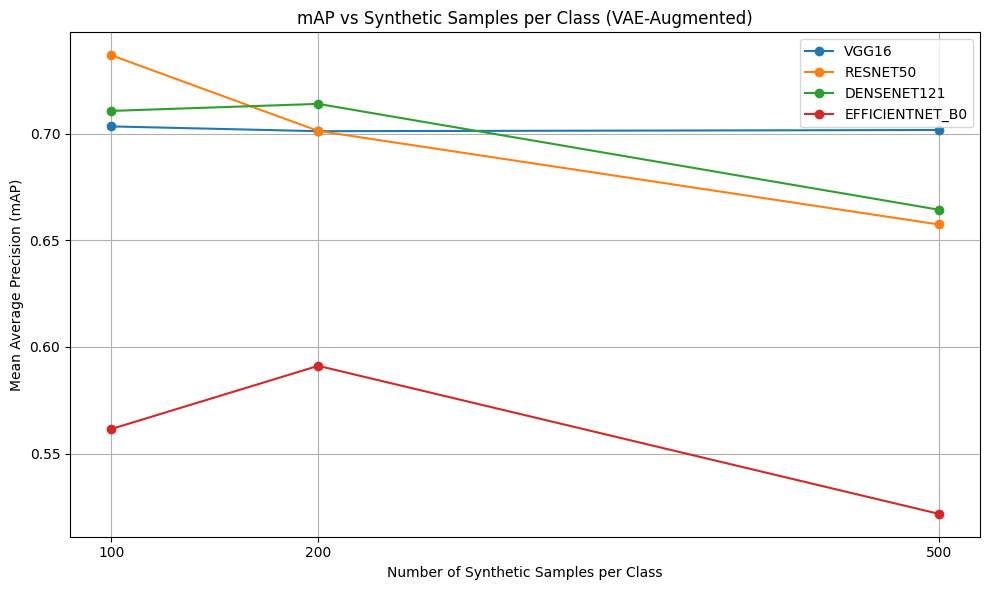

In [19]:

import matplotlib.pyplot as plt

# === PLOT mAP COMPARISON CURVES ===
def plot_map_trends(results_dict, model_names, samples_list):
    plt.figure(figsize=(10, 6))

    for model_name in model_names:
        mAPs = []
        for samples in samples_list:
            key = f"{model_name}_{samples}"
            if key in results_dict:
                mAPs.append(results_dict[key]["mean_ap"])
            else:
                mAPs.append(None)  # in case something's missing

        plt.plot(samples_list, mAPs, marker='o', label=model_name.upper())

    plt.title("mAP vs Synthetic Samples per Class (VAE-Augmented)")
    plt.xlabel("Number of Synthetic Samples per Class")
    plt.ylabel("Mean Average Precision (mAP)")
    plt.grid(True)
    plt.xticks(samples_list)
    plt.legend()
    plt.tight_layout()
    plt.savefig("vae_augmented_map_trend.png", dpi=300)
    plt.show()

# === CALL THE PLOT FUNCTION ===
plot_map_trends(augmented_results, model_names, samples_list)



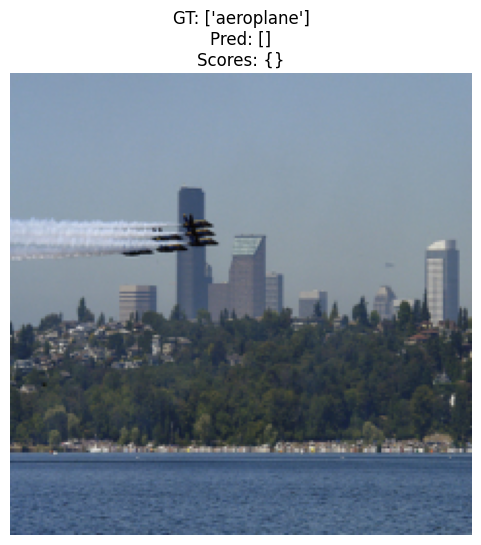

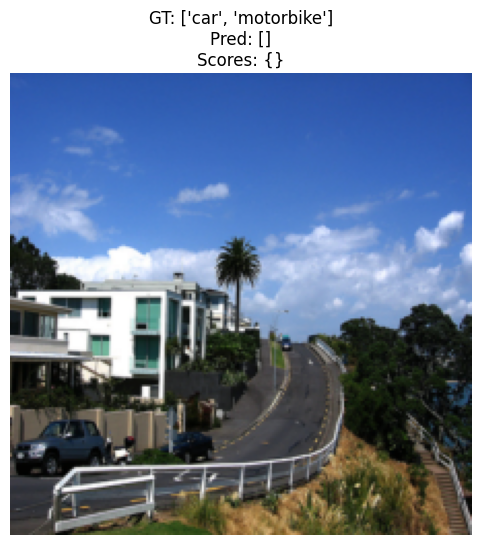

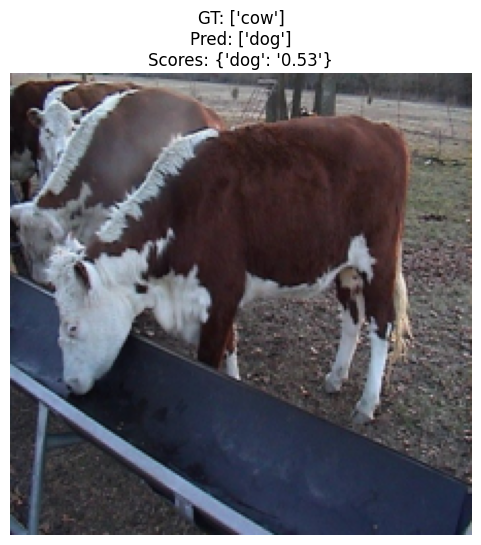

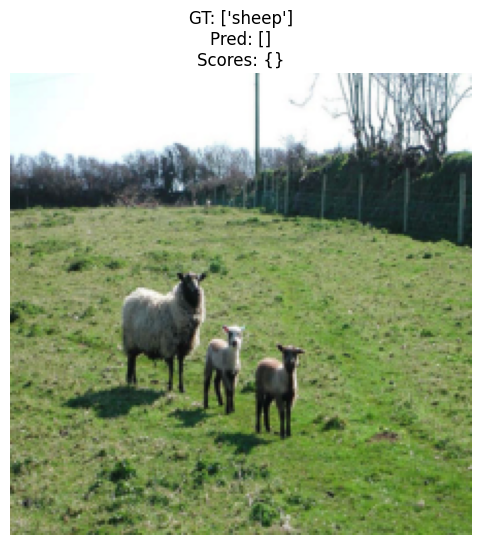

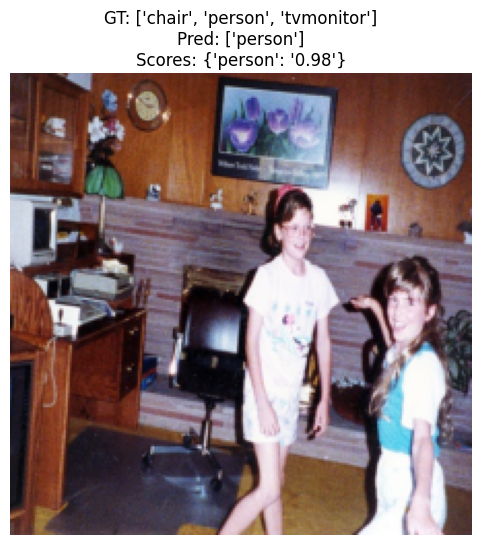

In [22]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Reverse normalization for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def display_predictions(model, data_loader, num_images=5, threshold=0.5):
    model.eval()
    model = model.cuda()
    shown = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.cuda()
            outputs = model(images)
            outputs = outputs.cpu().numpy()
            labels = labels.numpy()

            for i in range(images.size(0)):
                if shown >= num_images:
                    return

                img = images[i].cpu()
                img = inv_normalize(img)
                img = F.to_pil_image(img)

                true_labels = [VOC_CLASSES[j] for j, val in enumerate(labels[i]) if val == 1]
                pred_scores = outputs[i]
                pred_labels = [VOC_CLASSES[j] for j, score in enumerate(pred_scores) if score >= threshold]
                pred_scores_dict = {VOC_CLASSES[j]: f"{score:.2f}" for j, score in enumerate(pred_scores) if score >= threshold}

                plt.figure(figsize=(6, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"GT: {true_labels}\nPred: {pred_labels}\nScores: {pred_scores_dict}")
                plt.show()

                shown += 1
display_predictions(trained_model, test_loader, num_images=5, threshold=0.5)
